In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the provided Excel files
materials_db_path = 'Data/Materials_DB.xlsx'
data_path = 'Data/Data.xlsx'

materials_db = pd.ExcelFile(materials_db_path)
data = pd.ExcelFile(data_path)

materials_solids = materials_db.parse('Solids')
materials_concentrates = materials_db.parse('Concentrates')
production_data = data.parse('Production')


In [3]:

# Analyze material diversity
solids_materials = materials_solids.iloc[3:, [1]].dropna().rename(columns={"Unnamed: 1": "Material"})
concentrates_materials = materials_concentrates.iloc[2:, [2]].dropna().rename(columns={"Unnamed: 2": "Material"})

solids_count = solids_materials["Material"].nunique()
concentrates_count = concentrates_materials["Material"].nunique()

all_materials = pd.concat([solids_materials, concentrates_materials], ignore_index=True)
all_materials_unique = all_materials["Material"].nunique()

overlap_count = len(set(solids_materials["Material"]).intersection(set(concentrates_materials["Material"])))
unique_solids = solids_count - overlap_count
unique_concentrates = concentrates_count - overlap_count

material_diversity_summary = {
    "Unique Materials (Solids)": solids_count,
    "Unique Materials (Concentrates)": concentrates_count,
    "Total Unique Materials (Combined)": all_materials_unique,
    "Overlapping Materials": overlap_count,
    "Unique to Solids": unique_solids,
    "Unique to Concentrates": unique_concentrates,
}

material_diversity_summary


{'Unique Materials (Solids)': 238,
 'Unique Materials (Concentrates)': 352,
 'Total Unique Materials (Combined)': 590,
 'Overlapping Materials': 0,
 'Unique to Solids': 238,
 'Unique to Concentrates': 352}

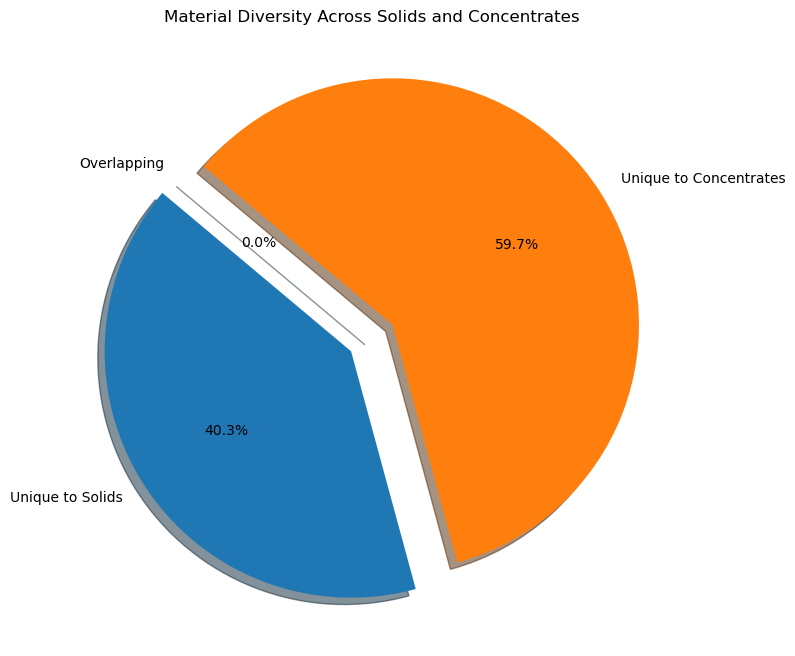

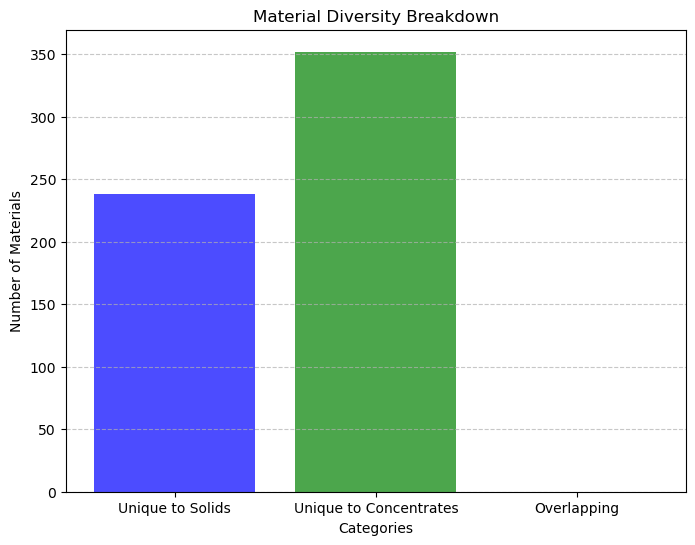

In [4]:

# Visualize material diversity
categories = ['Unique to Solids', 'Unique to Concentrates', 'Overlapping']
values = [unique_solids, unique_concentrates, overlap_count]

plt.figure(figsize=(8, 8))
plt.pie(
    values,
    labels=categories,
    autopct='%1.1f%%',
    startangle=140,
    explode=(0.1, 0.1, 0),
    shadow=True
)
plt.title("Material Diversity Across Solids and Concentrates")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['blue', 'green', 'gray'], alpha=0.7)
plt.title("Material Diversity Breakdown")
plt.ylabel("Number of Materials")
plt.xlabel("Categories")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


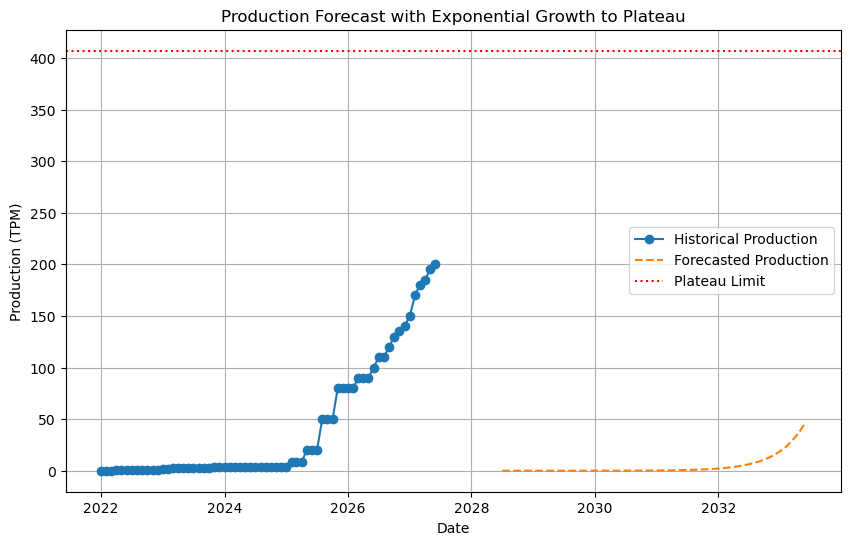

In [5]:

# Production data forecast
production_data['Date'] = pd.to_datetime(production_data['Date'])
initial_tons = production_data['TPM'].iloc[0]

future_months = 60
future_dates = pd.date_range(start=production_data['Date'].iloc[-1], periods=future_months, freq='M')
growth_rate = 0.2
plateau_limit = np.random.randint(300, 500)
production_forecast = [initial_tons]

for _ in range(1, future_months):
    next_value = production_forecast[-1] * (1 + growth_rate)
    if next_value > plateau_limit:
        next_value = plateau_limit
    production_forecast.append(next_value)

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Production (TPM)": production_forecast
})

plt.figure(figsize=(10, 6))
plt.plot(production_data['Date'], production_data['TPM'], label="Historical Production", marker='o')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Production (TPM)'], label="Forecasted Production", linestyle='--')
plt.axhline(y=plateau_limit, color='r', linestyle=':', label="Plateau Limit")
plt.xlabel("Date")
plt.ylabel("Production (TPM)")
plt.title("Production Forecast with Exponential Growth to Plateau")
plt.legend()
plt.grid()
plt.show()


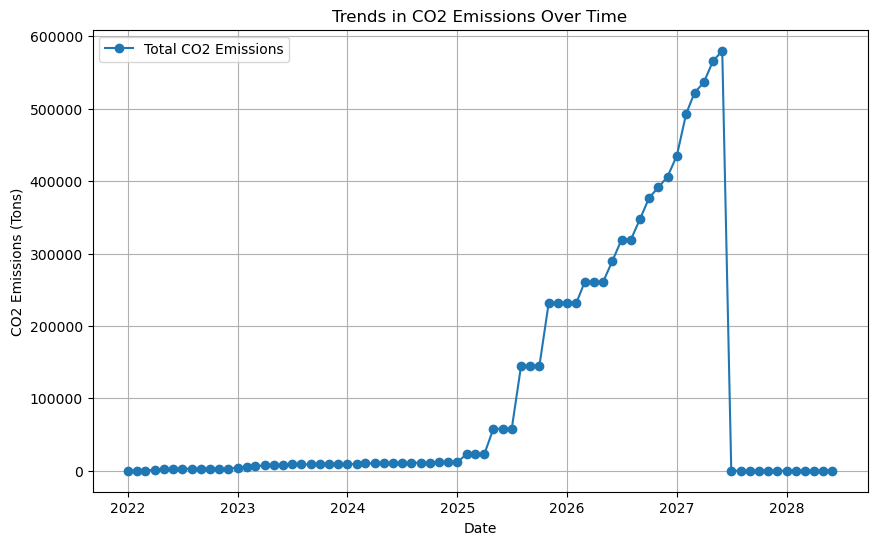

In [6]:

# Analyze CO2 emissions trends
co2_columns_corrected = ['MyBC growth CO2 Produced Tons (1,6 kg per ton)', 'Plastic encineration(2.9kg CO2 per kg)']
production_data['Total CO2 Emissions'] = production_data[co2_columns_corrected].sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(production_data['Date'], production_data['Total CO2 Emissions'], label="Total CO2 Emissions", marker='o')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions (Tons)")
plt.title("Trends in CO2 Emissions Over Time")
plt.legend()
plt.grid()
plt.show()


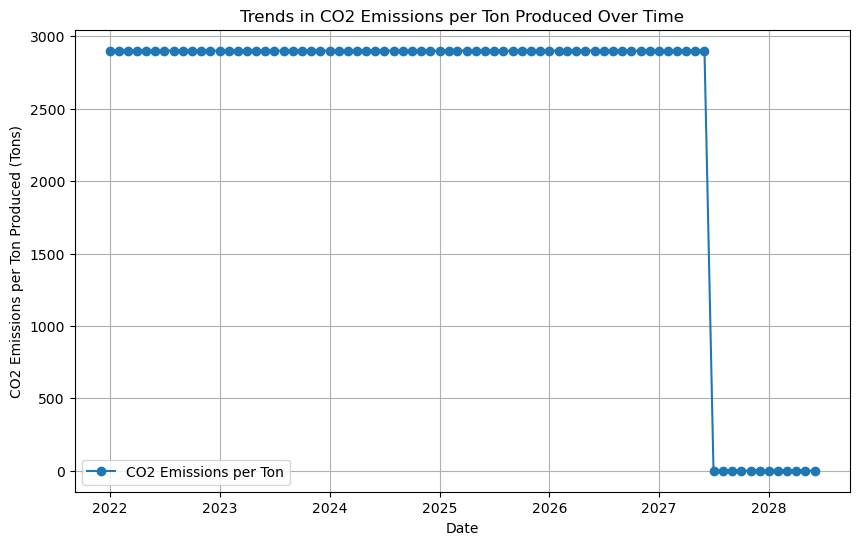

In [7]:

# CO2 emissions per ton of production
production_data['CO2 Emissions per Ton'] = production_data['Total CO2 Emissions'] / production_data['TPM']
production_data['CO2 Emissions per Ton'].replace([np.inf, -np.inf], np.nan, inplace=True)
production_data['CO2 Emissions per Ton'].fillna(0, inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(production_data['Date'], production_data['CO2 Emissions per Ton'], label="CO2 Emissions per Ton", marker='o')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions per Ton Produced (Tons)")
plt.title("Trends in CO2 Emissions per Ton Produced Over Time")
plt.legend()
plt.grid()
plt.show()


In [8]:

# Recommendations to reduce CO2 emissions
recommendations = '''
1. Optimize production efficiency through resource utilization and process automation.
2. Transition to renewable energy sources like solar and wind power.
3. Implement carbon capture and utilization technologies.
4. Substitute high-emission materials with sustainable alternatives.
5. Optimize logistics and use electric or hybrid transportation.
6. Electrify processes using renewable electricity.
7. Reduce plastic incineration by recycling and developing biodegradable alternatives.
8. Adopt circular economy practices for waste and resource management.
9. Monitor CO2 emissions in real time to address hotspots.
10. Engage stakeholders to align on sustainability goals.
'''
print(recommendations)



1. Optimize production efficiency through resource utilization and process automation.
2. Transition to renewable energy sources like solar and wind power.
3. Implement carbon capture and utilization technologies.
4. Substitute high-emission materials with sustainable alternatives.
5. Optimize logistics and use electric or hybrid transportation.
6. Electrify processes using renewable electricity.
7. Reduce plastic incineration by recycling and developing biodegradable alternatives.
8. Adopt circular economy practices for waste and resource management.
9. Monitor CO2 emissions in real time to address hotspots.
10. Engage stakeholders to align on sustainability goals.



In [9]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare production data for ARIMA
production_series = production_data.set_index('Date')['TPM']

# Check for stationarity using ADF test
adf_test = adfuller(production_series)
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Stationary": adf_test[1] <= 0.05
}

# Difference the data if necessary
if not adf_result["Stationary"]:
    production_series_diff = production_series.diff().dropna()
else:
    production_series_diff = production_series

# Fit the ARIMA model (parameters chosen tentatively, can be optimized)
p, d, q = 1, 1, 1
arima_model = ARIMA(production_series, order=(p, d, q))
arima_fitted = arima_model.fit()

# Forecast future values
forecast_steps = 24
forecast = arima_fitted.forecast(steps=forecast_steps)

# Create a forecast DataFrame
forecast_dates = pd.date_range(start=production_series.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_df = pd.DataFrame({"Date": forecast_dates, "Forecasted Production (TPM)": forecast.values})

# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(production_series, label="Historical Production")
plt.plot(forecast_df['Date'], forecast_df['Forecasted Production (TPM)'], label="ARIMA Forecast", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Production (TPM)")
plt.title("ARIMA-Based Production Forecast")
plt.legend()
plt.grid()
plt.show()

# Display the results
import ace_tools as tools; tools.display_dataframe_to_user(name="ARIMA Forecast Data", dataframe=forecast_df)


MissingDataError: exog contains inf or nans